## Trabajo Fin de Máster <br/> Diseño de una arquitectura multimodal para descripción textual de pares imagen-audio

## Script 2. Entrenamiento de un clasificador de audio usando PyTorch

En este notebook, aprendemos a clasificar los audios que hemos generado, con la ayuda de PyTorch. Para ello, usamos lo compartido en el artículo de [TowardsDataScience](https://towardsdatascience.com/audio-deep-learning-made-simple-sound-classification-step-by-step-cebc936bbe5).

### Paso 1. Cambio de directorio e importaciones necesarias

In [1]:
import os
os.chdir('..')
os.getcwd()

'/mnt/batch/tasks/shared/LS_root/mounts/clusters/tfm-cpu/code/Users/jose.puche/Scripts'

### Paso 2. Configuración e inicialización de wandb

In [2]:
# WandB – Login to your wandb account so you can log all your metrics
import wandb

In [3]:
!wandb login 1b8abaacf33b7b5812267384768c22a1eef3c11e

wandb: Appending key for api.wandb.ai to your netrc file: /home/azureuser/.netrc


In [4]:
folder_path = './../Final_Database'
num_epochs = 30
BATCH_SIZE = 16
lr = 1e-3
output_dim = 40

model_parameters_file = f"./modelos/audio/AUDIO_{output_dim}pers_lr{f'{lr:.0e}'}_bs{BATCH_SIZE}_{num_epochs}ep.pt"
model_parameters_file

'./modelos/audio/AUDIO_40pers_lr1e-03_bs16_30ep.pt'

In [5]:
# WandB – Initialize a new run
run_name = model_parameters_file.split("/")[-1].replace('.pt', '')
wandb.init(entity="josealbertoap", project='TFM', name = run_name, tags=["audio"])

# WandB – Config is a variable that holds and saves hyperparameters and inputs
config = wandb.config          # Initialize config
config.batch_size = BATCH_SIZE          # input batch size for training (default: 64)
config.test_batch_size = BATCH_SIZE    # input batch size for testing (default: 1000)
config.epochs = num_epochs             # number of epochs to train (default: 10)
config.lr = lr              # learning rate (default: 0.01)
config.momentum = 0          # SGD momentum (default: 0.5)
config.no_cuda = True         # disables CUDA training
config.seed = 0               # random seed (default: 42)
config.log_interval = 1     # how many batches to wait before logging training status
config.num_classes = output_dim

wandb: Currently logged in as: josealbertoap. Use `wandb login --relogin` to force relogin


### Paso 2. Lectura de los audios generados
Leemos los audios de nuestra base de datos y los guardamos en un dataset compuesto por sus respectivos espectrogramas.

Posteriormente, usamos los datasets de entrenamiento y validación para generar los respectivos DataLoaders que emplearemos en el entrenamiento de la red.

In [6]:
import random
import numpy as np
import torch

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

set_seed(config.seed)

In [7]:
import pandas as pd
from torch.utils.data import random_split
from tfm_lib.datasets import SoundDS

database_df = pd.read_csv(f"{folder_path}/audio/audioDB_train.csv")
myds = SoundDS(database_df, './', output_dim)

# Random split of 80:20 between training and validation
num_items = len(myds)
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_ds, val_ds = random_split(myds, [num_train, num_val])

# Create training and validation data loaders
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=1048, shuffle=False)

### Paso 3. Entrenamiento de la red

In [8]:
from torch import nn
from tqdm import tqdm
from tfm_lib.EarlyStopping import EarlyStopping

# ----------------------------
# Training Loop
# ----------------------------
def training(model, train_dl, val_dl, num_epochs):
  # Loss Function, Optimizer and Scheduler
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(),lr=lr)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 4)

  # Inicializar EarlyStopping
  early_stopping = EarlyStopping(patience=5, verbose=True, delta=0.01, path=model_parameters_file)

  train_loss = {}
  test_loss = {}
  train_acc = {}
  test_acc = {}

  # Repeat for each epoch
  for epoch in range(num_epochs):
    model.train()

    running_loss = 0.0
    correct_prediction = 0
    total_prediction = 0

    train_steps = tqdm(train_dl, unit="batch")

    # Repeat for each batch in the training set
    for i, data in enumerate(train_steps):

        train_steps.set_description(f"Epoch [{epoch+1}/{num_epochs}]. Training")

        # Get the input features and target labels, and put them on the GPU
        inputs, labels = data[0].to(device), data[1].to(device)

        # Normalize the inputs
        inputs_m, inputs_s = inputs.mean(), inputs.std()
        inputs = (inputs - inputs_m) / inputs_s

        # Zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # scheduler.step()

        # Keep stats for Loss and Accuracy
        running_loss += loss.item()

        # Get the predicted class with the highest score
        _, prediction = torch.max(outputs,1)
        # Count of predictions that matched the target label
        correct_prediction += (prediction == labels).sum().item()
        total_prediction += prediction.shape[0]

        train_steps.set_postfix(mean_loss=running_loss/total_prediction, mean_accuracy = correct_prediction / total_prediction)

    # Print stats at the end of the epoch
    num_batches = len(train_dl)
    avg_loss = running_loss / num_batches
    acc = correct_prediction/total_prediction
    print(f'Epoch [{epoch+1}/{num_epochs}]:')
    print(f'Training. Loss: {avg_loss:.2f}, Accuracy: {acc:.2f}')

    train_loss[epoch+1] = avg_loss
    train_acc[epoch+1] = acc

    # Validación del modelo
    model.eval()
    correct_prediction = 0
    total_prediction = 0
    running_loss = 0

    # Disable gradient updates
    with torch.no_grad():

      predictions = []
      label_list = []
      for data in val_dl:
        # Get the input features and target labels, and put them on the GPU
        inputs, labels = data[0].to(device), data[1].to(device)

        # Normalize the inputs
        inputs_m, inputs_s = inputs.mean(), inputs.std()
        inputs = (inputs - inputs_m) / inputs_s

        # Get predictions
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # Get the predicted class with the highest score
        _, prediction = torch.max(outputs,1)
        # Count of predictions that matched the target label
        correct_prediction += (prediction == labels).sum().item()
        total_prediction += prediction.shape[0]

        predictions.extend(prediction)
        label_list.extend(data[1])

    acc = correct_prediction/total_prediction
    val_loss = running_loss / len(val_dl)

    print(f'Validation. Loss: {val_loss:.6f}, Accuracy: {acc:.6f}')

    test_loss[epoch+1] = val_loss
    test_acc[epoch+1] = acc

    # Llamar a early_stopping con la pérdida de validación actual y el modelo
    early_stopping(val_loss, model)
    print('')

    # Si se alcanza el criterio de early stopping, romper el bucle
    if early_stopping.early_stop:
        print("Early stopping")
        break
      
    # Cambiar learning rate si hace falta
    scheduler.step(test_loss[epoch+1])

    wandb.log({
      'Epoch': epoch+1,
      'Training Loss': train_loss[epoch+1],
      'Training Accuracy': train_acc[epoch+1],
      'Evaluation Loss': test_loss[epoch+1],
      'Evaluation Accuracy': test_acc[epoch+1],
      })

  print('Finished Training')

  return {'train_acc': train_acc, 'train_loss': train_loss, 'val_acc': test_acc, 'val_loss': test_loss}

In [9]:
# Create the model and put it on the GPU if available
from tfm_lib.modelos import AudioClassifier
model = AudioClassifier(output_dim)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

wandb.watch(model, log="all")

# Run the training process
training_results = training(model, train_dl, val_dl, num_epochs)

print(training_results)
wandb.save(model_parameters_file)

/anaconda/envs/jupyter_env/lib/python3.9/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
Epoch [23/30]. Training: 100%|██████████| 73/73 [04:17<00:00,  3.53s/batch, mean_accuracy=0.996, mean_loss=0.00457]


Epoch [1/30]:
Training. Loss: 3.52, Accuracy: 0.11
Validation. Loss: 3.226275, Accuracy: 0.162069
Validation loss decreased (inf --> 3.226275).  Saving model ...

Epoch [2/30]:
Training. Loss: 3.03, Accuracy: 0.27
Validation. Loss: 2.733552, Accuracy: 0.296552
Validation loss decreased (3.226275 --> 2.733552).  Saving model ...

Epoch [3/30]:
Training. Loss: 2.53, Accuracy: 0.44
Validation. Loss: 2.345152, Accuracy: 0.400000
Validation loss decreased (2.733552 --> 2.345152).  Saving model ...

Epoch [4/30]:
Training. Loss: 2.07, Accuracy: 0.59
Validation. Loss: 1.994113, Accuracy: 0.586207
Validation loss decreased (2.345152 --> 1.994113).  Saving model ...

Epoch [5/30]:
Training. Loss: 1.65, Accuracy: 0.70
Validation. Loss: 1.712339, Accuracy: 0.689655
Validation loss decreased (1.994113 --> 1.712339).  Saving model ...

Epoch [6/30]:
Training. Loss: 1.30, Accuracy: 0.80
Validation. Loss: 1.545423, Accuracy: 0.741379
Validation loss decreased (1.712339 --> 1.545423).  Saving model ..

['/mnt/batch/tasks/shared/LS_root/mounts/clusters/tfm-cpu/code/Users/jose.puche/Scripts/wandb/run-20240723_072309-zwfksvde/files/modelos/audio/AUDIO_40pers_lr1e-03_bs16_30ep.pt']

No such comm: f27e6986482e4e8a8e59fd991ab82aec


### Paso 4. Resultados con los datos de test

In [10]:
test_dataset = SoundDS(pd.read_csv(f"{folder_path}/audio/audioDB_test.csv"), './', output_dim)
test_dl = torch.utils.data.DataLoader(test_dataset, batch_size=1048, shuffle=True)

In [11]:
# ----------------------------
# Inference
# ----------------------------
def inference (model, val_dl):
  correct_prediction = 0
  total_prediction = 0

  # Disable gradient updates
  with torch.no_grad():

    predictions = []
    label_list = []
    for data in val_dl:
      # Get the input features and target labels, and put them on the GPU
      inputs, labels = data[0].to(device), data[1].to(device)

      # Normalize the inputs
      inputs_m, inputs_s = inputs.mean(), inputs.std()
      inputs = (inputs - inputs_m) / inputs_s

      # Get predictions
      outputs = model(inputs)

      # Get the predicted class with the highest score
      _, prediction = torch.max(outputs,1)
      # Count of predictions that matched the target label
      correct_prediction += (prediction == labels).sum().item()
      total_prediction += prediction.shape[0]

      predictions.extend(prediction)
      label_list.extend(data[1])

  acc = correct_prediction/total_prediction
  print(f'Accuracy: {acc:.2f}, Total items: {total_prediction}')

  return predictions, label_list

# Run inference on trained model with the validation set
model.load_state_dict(torch.load(model_parameters_file, map_location=torch.device('cpu')))
result = inference(model, test_dl)

Accuracy: 0.96, Total items: 290


{'Test accuracy': 0.9586206896551724, 'Test precision': 0.9630528499278501, 'Test recall': 0.9620337301587302, 'F1-score': 0.9593265557971442}


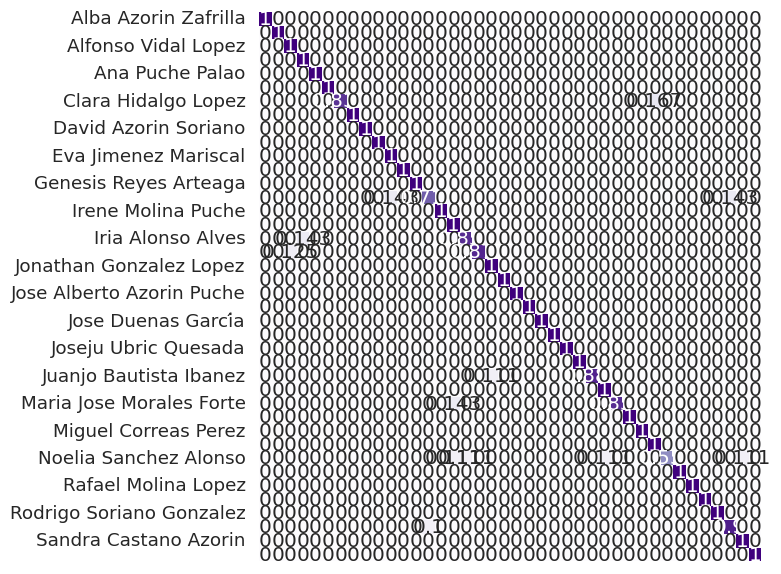

In [12]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, f1_score, confusion_matrix
import seaborn as sn
import numpy as np
import plotly
import matplotlib.pyplot as plt

def font_scale(num_classes):
    if num_classes <= 10:
        return 1.0
    elif num_classes <= 20:
        return 0.75
    elif num_classes <= 30:
        return 0.65
    else:
        return 0.45

def plot_confusion_matrix(y_true, y_pred):
    cf_matrix = confusion_matrix(y_true, y_pred)

    df_cm = pd.DataFrame((cf_matrix / np.sum(cf_matrix, axis=1)[:, None]).round(3),
                         index=myds.labelencoder().classes_,
                         columns=myds.labelencoder().classes_)
    
    plt.figure(figsize=(8, 6))  
    sn.set(font_scale = font_scale(df_cm.shape[0]))  
    heatmap = sn.heatmap(df_cm, annot=True, cbar=False, cmap='Purples', fmt='g', xticklabels=False)

    # Ajusta la rotación y alineación de los ticks de los ejes
    heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0, ha='right')

    plt.tight_layout()  # Asegura que todo se ajuste bien en la figura
    plt.savefig(model_parameters_file.replace('/modelos/', '/results/').replace('.pt', '.png'))

    return plt.gcf()

def get_metrics(result):
    accuracy = accuracy_score(result[1], result[0])
    precision = precision_score(result[1], result[0], average='macro')
    recall = recall_score(result[1], result[0], average='macro')
    f1 = f1_score(result[1], result[0], average='macro')

    metrics = {
        'Test accuracy': accuracy,
        'Test precision': precision,
        'Test recall': recall,
        'F1-score': f1
    }

    print(metrics)

    metrics['Confusion Matrix'] = wandb.Image(plot_confusion_matrix(result[1],result[0]))
    metrics['Test metrics'] = wandb.Table(columns=["Metric name", "Value"], 
                                          data=[["Test accuracy", accuracy], ["Test precision", precision],
                                                ["Test recall", recall], ["Test F1-Score", f1]])

    return metrics

metrics = get_metrics(result)
wandb.log(metrics)

In [13]:
wandb.finish()

Epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
Evaluation Accuracy,▁▂▃▅▆▆▆▇█▇▇██▇████████
Evaluation Loss,█▇▆▅▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁
F1-score,▁
Test accuracy,▁
Test precision,▁
Test recall,▁
Training Accuracy,▁▂▄▅▆▆▇▇▇█████████████
Training Loss,█▇▆▅▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Epoch,22
Evaluation Accuracy,0.96552
